# Mellinguer complete

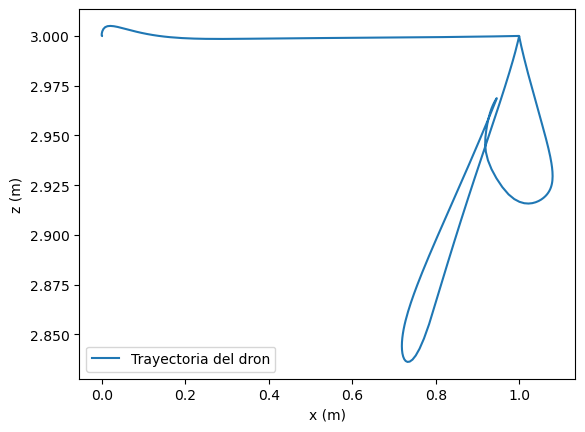

In [16]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerController


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quadrotor_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core")
if drone_id < 0:
    raise ValueError("No existe el body 'core' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()

# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerController(mass=m, gravity=9.81, gains=gains)

# (Opcional) si quieres asignar por nombre para evitar depender del orden:
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")

# guardar para debug/visualización
vector_r = []
vector_rT = []
rT = p0.copy()  # referencia inicial

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)
        vector_rT.append(rT)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        vel_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) Referencia deseada (ejemplo: oscilación en x)
        # ---------------------------
        x_d = 1 #0.5 * np.sin(0.5 * t)
        x_dot_d = 0 #0.25 * np.cos(0.5 * t)
        x_ddot_d = 0 #-0.125 * np.sin(0.5 * t)

        rT = np.array([p0[0] + x_d, p0[1], p0[2]])
        vT = np.array([x_dot_d, 0.0, 0.0])
        aT = np.array([x_ddot_d, 0.0, 0.0])

        yaw_d = 0.0

        # ---------------------------
        # (3) Control Mellinger -> u = [u1,u2,u3,u4]
        # ---------------------------
        u = controller.step(rT, vT, aT, r, vel_world, R, omega_body, yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = u[0]
        data.ctrl[act_u2] = u[1]
        data.ctrl[act_u3] = u[2]
        data.ctrl[act_u4] = u[3]

        # ---------------------------
        # (5) Paso de simulación
        # ---------------------------
        start = time.time()

        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()


# Mellinguer modified

In [ ]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerControllerModified


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quadrotor_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core")
if drone_id < 0:
    raise ValueError("No existe el body 'core' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()

# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerControllerModified(mass=m, gravity=9.81, gains=gains)

# (Opcional) si quieres asignar por nombre para evitar depender del orden:
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")

# guardar para debug/visualización
vector_r = []
vector_rT = []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)
        # vector_rT.append(rT)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        vel_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) Referencia deseada (ejemplo: oscilación en x)
        # ---------------------------
        x_d = 1 #0.5 * np.sin(0.5 * t)
        x_dot_d = 0 #0.25 * np.cos(0.5 * t)
        x_ddot_d = 0 #-0.125 * np.sin(0.5 * t)

        rT = np.array([p0[0] + x_d, p0[1], p0[2]])
        vT = np.array([x_dot_d, 0.0, 0.0])
        aT = np.array([x_ddot_d, 0.0, 0.0])

        yaw_d = 0.0

        # funcion seno
        F_des = np.array([0.0, 0.0, m*9.81 + 0.5 * np.sin(2 * t)])  # Solo queremos hover, fuerza hacia arriba igual al peso

        # F_des = np.array([0.0, 0.0, m*9.81 + np.sin()])  # Solo queremos hover, fuerza hacia arriba igual al peso

        # ---------------------------
        # (3) Control Mellinger -> u = [u1,u2,u3,u4]
        # ---------------------------
        u = controller.step(F_des, R, omega_body, yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = u[0]
        data.ctrl[act_u2] = u[1]
        data.ctrl[act_u3] = u[2]
        data.ctrl[act_u4] = u[3]

        # ---------------------------
        # (5) Paso de simulación
        # ---------------------------
        start = time.time()

        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)
plt.legend()
plt.show()


# Mellinguer two drones

In [ ]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerController


def quat_to_rotmat(q):
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML 2 drones con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/quadrotors_with_flexrod_u1234.xml"   # <-- cambia al nombre real

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# IDs de cuerpos
id_core1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core_1")
id_core2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core_2")
if id_core1 < 0 or id_core2 < 0:
    raise ValueError("No encontré core_1 / core_2 en el XML.")

# Masa total por dron (subtree)
m1 = float(model.body_subtreemass[id_core1])
m2 = float(model.body_subtreemass[id_core2])

# Forward una vez
mujoco.mj_forward(model, data)
p01 = data.xpos[id_core1].copy()
p02 = data.xpos[id_core2].copy()

# Gains (una sola instancia por dron; puedes usar mismos gains o distintos)
gains = [
    np.array([5.0, 5.0, 10.0]),     # Kp
    np.array([3.0, 3.0, 6.0]),      # Kv
    np.array([8.0, 8.0, 2.0]),    # KR (bajitas para evitar vibración)
    np.array([0.2, 0.2, 0.1])       # Komega
]

ctrl1 = MellinguerController(mass=m1, gravity=9.81, gains=gains)
ctrl2 = MellinguerController(mass=m2, gravity=9.81, gains=gains)

# IDs de actuadores (por nombre)
def act_id(name: str) -> int:
    aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
    if aid < 0:
        raise ValueError(f"No encontré el actuator '{name}'. Revisa el XML.")
    return aid

u1_1 = act_id("u1_thrust_1")
u2_1 = act_id("u2_tau_x_1")
u3_1 = act_id("u3_tau_y_1")
u4_1 = act_id("u4_tau_z_1")

u1_2 = act_id("u1_thrust_2")
u2_2 = act_id("u2_tau_x_2")
u3_2 = act_id("u3_tau_y_2")
u4_2 = act_id("u4_tau_z_2")

# Debug
traj1, traj1_ref = [], []
traj2, traj2_ref = [], []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # =========================
        # Estado dron 1
        # =========================
        r1 = data.xpos[id_core1].copy()
        q1 = data.xquat[id_core1].copy()
        R1 = quat_to_rotmat(q1)

        cvel1 = data.cvel[id_core1].copy()  # [w, v] world-aligned
        omega1_world = cvel1[0:3]
        v1_world = cvel1[3:6]
        omega1_body = R1.T @ omega1_world

        # =========================
        # Estado dron 2
        # =========================
        r2 = data.xpos[id_core2].copy()
        q2 = data.xquat[id_core2].copy()
        R2 = quat_to_rotmat(q2)

        cvel2 = data.cvel[id_core2].copy()
        omega2_world = cvel2[0:3]
        v2_world = cvel2[3:6]
        omega2_body = R2.T @ omega2_world

        # =========================
        # Referencias (ejemplo simple)
        # - dron 1 va a x = p01[0] + 1
        # - dron 2 va a x = p02[0] - 1
        # =========================
        x_d = 0.0
        x_dot_d = 0.0
        x_ddot_d = 0.0

        rT1 = np.array([p01[0] + x_d, p01[1], p01[2]+1])
        vT1 = np.array([x_dot_d, 0.0, 0.0])
        aT1 = np.array([x_ddot_d, 0.0, 0.0])
        yaw1 = 0.0

        rT2 = np.array([p02[0] - x_d, p02[1], p02[2]+1])
        vT2 = np.array([x_dot_d, 0.0, 0.0])
        aT2 = np.array([x_ddot_d, 0.0, 0.0])
        yaw2 = 0.0

        # =========================
        # Control -> u=[u1,u2,u3,u4] por dron
        # =========================
        u_1 = ctrl1.step(rT1, vT1, aT1, r1, v1_world, R1, omega1_body, yaw1)
        u_2 = ctrl2.step(rT2, vT2, aT2, r2, v2_world, R2, omega2_body, yaw2)

        # =========================
        # Aplicar controles directos
        # =========================
        data.ctrl[u1_1] = u_1[0]
        data.ctrl[u2_1] = u_1[1]
        data.ctrl[u3_1] = u_1[2]
        data.ctrl[u4_1] = u_1[3]

        data.ctrl[u1_2] = u_2[0]
        data.ctrl[u2_2] = u_2[1]
        data.ctrl[u3_2] = u_2[2]
        data.ctrl[u4_2] = u_2[3]

        # Debug
        traj1.append(r1); traj1_ref.append(rT1)
        traj2.append(r2); traj2_ref.append(rT2)

        # =========================
        # Step MuJoCo
        # =========================
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # tiempo real (opcional)
        elapsed = time.time() - start
        if dt - elapsed > 0:
            time.sleep(dt - elapsed)


# Plot rápido (opcional)
import matplotlib.pyplot as plt
traj1 = np.array(traj1); traj1_ref = np.array(traj1_ref)
traj2 = np.array(traj2); traj2_ref = np.array(traj2_ref)

plt.figure()
plt.plot(traj1[:,0], traj1[:,2], label="dron1 x-z")
plt.plot(traj1_ref[:,0], traj1_ref[:,2], "--", label="ref1 x-z")
plt.plot(traj2[:,0], traj2[:,2], label="dron2 x-z")
plt.plot(traj2_ref[:,0], traj2_ref[:,2], "--", label="ref2 x-z")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.legend()
plt.show()


# With MPPI planner

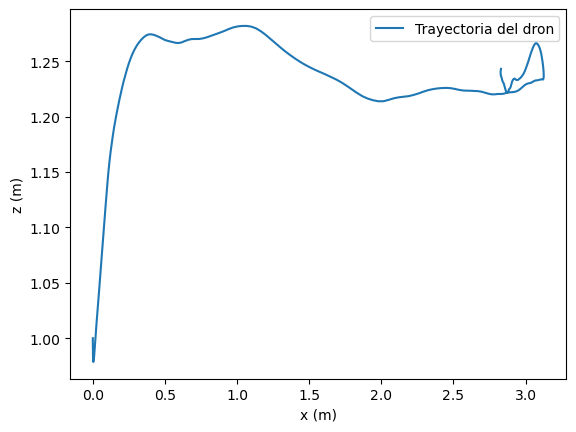

In [7]:
import time
import numpy as np
import mujoco
from mujoco import viewer
from mellinguer_diy import MellinguerControllerModified
from MPPI import SingleMPPIPlanner
from dynamics import SingleMassDynamicModel

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quad_obs_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "drone_3d")
if drone_id < 0:
    raise ValueError("No existe el body 'drone_3d' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# # Inercia (simplificada): usamos diagonal del body
# # (en modelos complejos esto no es perfecto, pero sirve para empezar)
# J_diag = model.body_inertia[drone_id].copy()
# J = np.diag(J_diag)

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()


############ MPPI Planner ##############

# IMPORTANTE: para hover necesitas Fz_max > m*9.81
Fxy = 8.0 * m     # fuerza lateral máxima
Fz_min = 0.0          # típico en quad: no hay empuje negativo (ajusta si tu modelo sí)
Fz_max = 25.0 * m   # fuerza vertical máxima (debe ser > m*9.81 para hover)

# Crear planner MPPI
planner = SingleMPPIPlanner(
    dt=dt,
    horizon=50,           # pasos
    num_samples=50,      # rollouts
    lambda_=1.0,
    noise_sigma=np.array([2.0*m, 2.0*m, 4.0*m]),  # ruido en newton step
    F_min=np.array([-Fxy, -Fxy, Fz_min]),
    F_max=np.array([Fxy, Fxy, Fz_max]),
    w_goal=6.0,
    w_terminal=50.0,
    w_F=0.03,
    w_smooth=0.02,
    w_obs=80.0,
    obs_margin=0.20,
    obs_softness=0.15,
    goal_tolerance=0.10,
    z_min=0.5,
    z_max=2.0,
    z_margin=0.15,
    w_z=200.0,
    w_z_terminal=400.0,
    rng_seed=0)

# model dynamics mass model
mass_model = SingleMassDynamicModel(dt=dt, mass=m)
planner.define_model(mass_model) # define modelo dinámico para MPPI

# Punto B (goal): ejemplo
goal = p0 + np.array([2.5, 0.0, 0.0])
planner.set_goal(goal)

# Obstáculos (deben coincidir con el XML)
obstacles = [
    {"type":"sphere", "c":[1.0,  0.0, 1.0], "r":0.25},
    {"type":"box",    "c":[1.6,  0.4, 1.0], "h":[0.20, 0.20, 0.40]},
    {"type":"box",    "c":[1.6, -0.4, 1.0], "h":[0.20, 0.20, 0.40]},
]
planner.set_obstacles(obstacles)


############# Mellinguer Controller ##################
# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerControllerModified(mass=m, gravity=9.81, gains=gains)

# Actuadores por nombre (para evitar depender del orden en el XML):
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")




############## SIMULACION ################



# guardar para debug/visualización
vector_r = []
# vector_rT = []
# rT = p0.copy()  # referencia inicial


with viewer.launch_passive(model, data) as vis:
    yaw_d = 0.0  # yaw objetivo fijo
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado real en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        v_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # # seguridad: solo empuje positivo en Z, fuerza que F_des[2] >= 0
        # if Fz_min >= 0.0:
        #     F_des = F_des.copy()
        #     F_des[2] = max(F_des[2], 0.0)

        # ---------------------------
        # (2) MPPI: fuerza deseada en mundo
        # ---------------------------
        F_des, _, _ = planner.compute_action(r, v_world)

        # ---------------------------
        # (3) Mellinger attitude: u = [u1, u2, u3, u4]
        # ---------------------------
        u = controller.step(F_des, R, omega_body, psi_T=yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = float(u[0])
        data.ctrl[act_u2] = float(u[1])
        data.ctrl[act_u3] = float(u[2])
        data.ctrl[act_u4] = float(u[3])

        # ---------------------------
        # (5) Step MuJoCo
        # ---------------------------
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()



# Single drone, TORCH

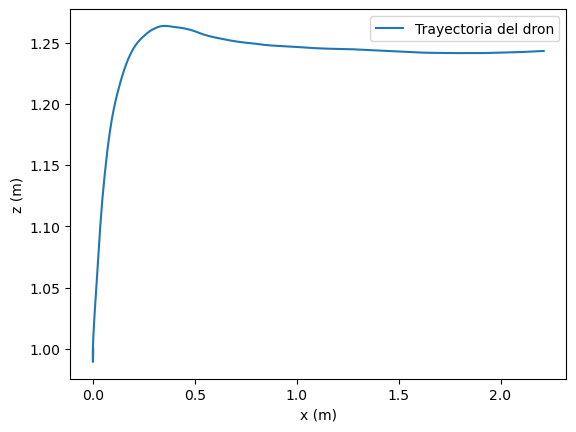

In [1]:
import time
import numpy as np
import mujoco
from mujoco import viewer
from mellinguer_diy import MellinguerControllerModified
from MPPI import SingleMPPIPlanner, SingleMPPIPlannerTorch
from dynamics import SingleMassDynamicModel, SingleMassDynamicModelTorch
from helper import quat_to_rotmat, ForceArrow

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.


############ MuJoCo ##############
# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quad_obs_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "drone_3d")
if drone_id < 0:
    raise ValueError("No existe el body 'drone_3d' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# obtener arrow para visualizar fuerzas (opcional, requiere que tengas un plugin o función para esto)
arrow = ForceArrow(model, data)

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()


############ MPPI Planner ##############

# IMPORTANTE: para hover necesitas Fz_max > m*9.81
Fxy = 8.0 * m     # fuerza lateral máxima
Fz_min = 0.0          # típico en quad: no hay empuje negativo (ajusta si tu modelo sí)
Fz_max = 25.0 * m   # fuerza vertical máxima (debe ser > m*9.81 para hover)

# Crear planner MPPI
mppi_every = 1  # cada cuántos steps correr MPPI (ajusta según tu hardware)

planner = SingleMPPIPlannerTorch(
    dt=dt*mppi_every,
    horizon=100,            # pasos
    num_samples=50000,       # rollouts
    lambda_=10.0,            # temperatura
    noise_sigma=np.array([2.0*m, 2.0*m, 4.0*m]),  # ruido en newton step
    F_min=np.array([-Fxy, -Fxy, Fz_min]),
    F_max=np.array([Fxy, Fxy, Fz_max]),
    w_goal=6.0,
    w_terminal=50.0,
    w_F=0.03,
    w_smooth=0.02,
    w_obs=80.0,
    obs_margin=0.20,
    obs_softness=0.15,
    goal_tolerance=0.10,
    # altura
    z_min=1.0,
    z_max=1.5,
    z_margin=0.15,
    w_z=200.0,
    w_z_terminal=400.0,
    # #velocidad
    v_max=4,
    v_margin=0.5,
    w_v=100.0,
    w_v_terminal=200.0,
    rng_seed=0,
    device="cuda")

# model dynamics mass model
mass_model = SingleMassDynamicModelTorch(dt=dt, mass=m, device="cuda")
planner.define_model(mass_model) # define modelo dinámico para MPPI

# Punto B (goal): ejemplo
goal = p0 + np.array([2.5, 0.0, 0.0])
planner.set_goal(goal)

# Obstáculos (deben coincidir con el XML)
obstacles = [
    {"type":"sphere", "c":[1.0,  0.0, 1.0], "r":0.25},
    {"type":"box",    "c":[1.6,  0.4, 1.0], "h":[0.20, 0.20, 0.40]},
    {"type":"box",    "c":[1.6, -0.4, 1.0], "h":[0.20, 0.20, 0.40]},
]
planner.set_obstacles(obstacles)


############# Mellinguer Controller ##################
# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerControllerModified(mass=m, gravity=9.81, gains=gains)

# Actuadores por nombre (para evitar depender del orden en el XML):
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")



################################################################################
##############################    SIMULACION    ################################
################################################################################

# guardar para debug/visualización
vector_r = []

# scheduler para MPPI
# mppi_every = 1 # ya esta antes de crear el planner, pero lo dejo aquí para referencia
F_des = np.array([0.0, 0.0, m*9.81], dtype=float)  # inicial hover
step_count = 0



with viewer.launch_passive(model, data) as vis:
    yaw_d = 0.0  # yaw objetivo fijo
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado real en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        v_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) MPPI: fuerza deseada en mundo (CON SCHEDULER)
        # ---------------------------if step_count % mppi_every == 0:
        if step_count % mppi_every == 0:
            F_des, _, _ , _ = planner.compute_action(r, v_world)
            # opcional: clip/safety
            F_des[2] = max(F_des[2], 0.0)

        step_count += 1

        # opcional: visualizar fuerza deseada en MuJoCo (requiere un plugin o función para esto)
        arrow.update_force_arrow_mocap(
            p0_world=r,          # origen en el centro del dron
            F_world=F_des,       # fuerza MPPI en world
            scale=0.03,
            max_len=0.8,
            radius=0.01)

        # ---------------------------
        # (3) Mellinger attitude: u = [u1, u2, u3, u4]
        # ---------------------------
        u = controller.step(F_des, R, omega_body, psi_T=yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = float(u[0])
        data.ctrl[act_u2] = float(u[1])
        data.ctrl[act_u3] = float(u[2])
        data.ctrl[act_u4] = float(u[3])

        # ---------------------------
        # (5) Step MuJoCo
        # ---------------------------
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # # sincronizar en tiempo real
        # elapsed = time.time() - start
        # sleep_time = dt - elapsed
        # if sleep_time > 0:
        #     time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()



# MPPI Single - Scheduler + ejecucion completa

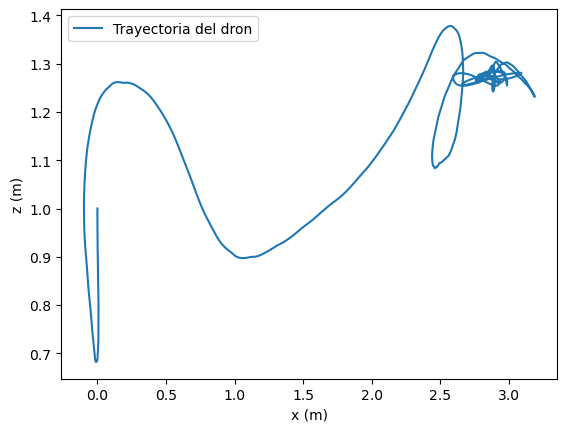

In [9]:
import time
import numpy as np
import mujoco
from mujoco import viewer
from mellinguer_diy import MellinguerControllerModified
from MPPI import SingleMPPIPlanner, SingleMPPIPlannerTorch
from dynamics import SingleMassDynamicModel, SingleMassDynamicModelTorch
from helper import quat_to_rotmat, ForceArrow

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.


############ MuJoCo ##############
# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quad_obs_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "drone_3d")
if drone_id < 0:
    raise ValueError("No existe el body 'drone_3d' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# obtener arrow para visualizar fuerzas (opcional, requiere que tengas un plugin o función para esto)
arrow = ForceArrow(model, data, arrow_idx=1)

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()


############ MPPI Planner ##############

# IMPORTANTE: para hover necesitas Fz_max > m*9.81
Fxy = 8.0 * m     # fuerza lateral máxima
Fz_min = 0.0          # típico en quad: no hay empuje negativo (ajusta si tu modelo sí)
Fz_max = 25.0 * m   # fuerza vertical máxima (debe ser > m*9.81 para hover)

# Crear planner MPPI
planner = SingleMPPIPlannerTorch(
    dt=dt,
    horizon=200,            # pasos
    num_samples=500000,       # rollouts
    lambda_=10.0,            # temperatura
    noise_sigma=np.array([2.0*m, 2.0*m, 4.0*m]),  # ruido en newton step
    F_min=np.array([-Fxy, -Fxy, Fz_min]),
    F_max=np.array([Fxy, Fxy, Fz_max]),
    w_goal=6.0,
    w_terminal=50.0,
    w_F=0.03,
    w_smooth=0.02,
    w_obs=80.0,
    obs_margin=0.20,
    obs_softness=0.15,
    goal_tolerance=0.10,
    # altura
    z_min=1.0,
    z_max=1.5,
    z_margin=0.15,
    w_z=200.0,
    w_z_terminal=400.0,
    #velocidad
    v_max=5.0,
    v_margin=0.5,
    w_v=100.0,
    w_v_terminal=200.0,
    rng_seed=0,
    device="cuda")

# model dynamics mass model
mass_model = SingleMassDynamicModelTorch(dt=dt, mass=m, device="cuda")
planner.define_model(mass_model) # define modelo dinámico para MPPI

# Punto B (goal): ejemplo
goal = p0 + np.array([2.5, 0.0, 1.0])
planner.set_goal(goal)

# Obstáculos (deben coincidir con el XML)
obstacles = [
    {"type":"sphere", "c":[1.0,  0.0, 1.0], "r":0.25},
    {"type":"box",    "c":[1.6,  0.4, 1.0], "h":[0.20, 0.20, 0.40]},
    {"type":"box",    "c":[1.6, -0.4, 1.0], "h":[0.20, 0.20, 0.40]},
]
planner.set_obstacles(obstacles)


############# Mellinguer Controller ##################
# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerControllerModified(mass=m, gravity=9.81, gains=gains)

# Actuadores por nombre (para evitar depender del orden en el XML):
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")



################################################################################
##############################    SIMULACION    ################################
################################################################################

# guardar para debug/visualización
vector_r = []

# scheduler para MPPI
# mppi_every = 1 # ya esta antes de crear el planner, pero lo dejo aquí para referencia
# mppi_every = 5            # MPPI cada 5 steps (ajusta)
# F_des = np.array([0.0, 0.0, m*9.81], dtype=float)  # inicial hover
# step_count = 0

# buffer para plan MPPI
mppi_every = 10            # MPPI cada 5 steps
plan_idx = mppi_every     # fuerza a planificar al inicio
F_plan = None             # buffer (H,3)

# fallback hover por si aún no hay plan
F_fallback = np.array([0.0, 0.0, m*9.81], dtype=float)

with viewer.launch_passive(model, data) as vis:
    yaw_d = 0.0  # yaw objetivo fijo
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado real en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        v_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) MPPI: fuerza deseada en mundo (CON SCHEDULER)
        # ---------------------------
        
        # (A) Replan cada mppi_every steps
        if plan_idx >= mppi_every or F_plan is None: # si es hora de replanificar o no hay plan
            F0, _, _, F_seq = planner.compute_action(r, v_world)  # F_seq: (H,3)
            F_plan = F_seq # guarda el plan completo
            plan_idx = 0 # reset del plan_idx para ejecutar desde el inicio del nuevo plan

        # (B) Ejecuta el siguiente comando del plan
        if plan_idx <= len(F_plan): # si el plan_idx está dentro del horizonte planificado
            F_des = F_plan[plan_idx] # toma la fuerza deseada del plan en el paso actual
        else: # si por alguna razón el plan_idx se salió del rango (debería ser raro), usa fallback
            F_des = F_fallback # fallback (hover) si algo salió mal con el plan

        plan_idx += 1 # incrementa el plan_idx para el próximo paso

        # seguridad: si tienes empuje negativo en Z
        F_des = F_des.copy()
        F_des[2] = max(F_des[2], 0.0)
        

        # visualizar fuerza deseada (opcional, requiere función/objeto para esto)
        arrow.update_force_arrow_mocap(
            p0_world=r,          # origen en el centro del dron
            F_world=F_des,       # fuerza MPPI en world
            scale=0.03,
            max_len=0.8,
            radius=0.01)

        # ---------------------------
        # (3) Mellinger attitude: u = [u1, u2, u3, u4]
        # ---------------------------
        u = controller.step(F_des, R, omega_body, psi_T=yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = float(u[0])
        data.ctrl[act_u2] = float(u[1])
        data.ctrl[act_u3] = float(u[2])
        data.ctrl[act_u4] = float(u[3])

        # ---------------------------
        # (5) Step MuJoCo
        # ---------------------------
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # # sincronizar en tiempo real
        # elapsed = time.time() - start
        # sleep_time = dt - elapsed
        # if sleep_time > 0:
        #     time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()



# Two Drones with Multi MPPI Planner

dt: 0.01 masses: [0.28 0.28] p0: [[ 0.  -0.5  1. ]
 [ 0.   0.5  1. ]]


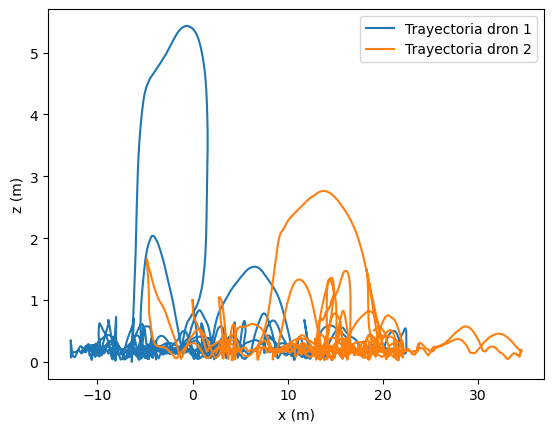

In [21]:
import time
import numpy as np
import mujoco
from mujoco import viewer
from mellinguer_diy import MellinguerControllerModified
from MPPI import SingleMPPIPlanner, SingleMPPIPlannerTorch, MultiMPPIPlannerTorch 
from dynamics import SingleMassDynamicModel, SingleMassDynamicModelTorch, MultiBodySpringDamperDynamicsTorch
from helper import quat_to_rotmat, ForceArrow

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.


############ MuJoCo ##############
# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/2_quad_obs_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body de los drones
drone_names = ["core_1", "core_2"]
drone_ids = []
for name in drone_names:
    bid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, name)
    if bid < 0:
        raise ValueError(f"No existe el body '{name}' en el XML.")
    drone_ids.append(bid)

drone_ids = np.array(drone_ids, dtype=int)
N = 2  # número de drones (agentes)

# Masas totales de los drones
masses = []
for bid in drone_ids:
    masses.append(float(model.body_subtreemass[bid]))
masses = np.array(masses, dtype=float)  # (2,)

# Forward, posición inicial para hover
mujoco.mj_forward(model, data)
p0 = np.stack([data.xpos[bid].copy() for bid in drone_ids], axis=0)  # (2,3)

print("dt:", dt, "masses:", masses, "p0:", p0)

# obtener arrow para visualizar fuerzas (opcional, requiere que tengas un plugin o función para esto)
arrow1 = ForceArrow(model, data, arrow_idx=1)
arrow2 = ForceArrow(model, data, arrow_idx=2)

############ MPPI Planner ##############

# IMPORTANTE: para hover necesitas Fz_max > m*9.81
Fxy = 8.0     # fuerza lateral máxima
Fz_min = 0.0          # típico en quad: no hay empuje negativo (ajusta si tu modelo sí)
Fz_max = 25.0   # fuerza vertical máxima (debe ser > m*9.81 para hover)

# Crear planner MPPI
planner = MultiMPPIPlannerTorch(
    N=N,                   # número de agentes (1 para single drone)
    dt=dt,
    horizon=200,            # pasos
    num_samples=500000,       # rollouts
    lambda_=10.0,            # temperatura
    noise_sigma=np.array([2.0, 2.0, 4.0]),  # ruido en newton step
    F_min=np.array([-Fxy, -Fxy, Fz_min]),
    F_max=np.array([Fxy, Fxy, Fz_max]),
    w_goal=6.0,
    w_terminal=50.0,
    w_F=0.03,
    w_smooth=0.02,
    w_obs=80.0,
    obs_margin=0.20,
    obs_softness=0.15,
    goal_tolerance=0.10,
    # altura
    z_min=1.0,
    z_max=1.5,
    z_margin=0.15,
    w_z=200.0,
    w_z_terminal=400.0,
    #velocidad
    v_max=5.0,
    v_margin=0.5,
    w_v=100.0,
    w_v_terminal=200.0,
    rng_seed=0,
    device="cuda")


# ---------------------------
# Dinámica acoplada resorte/amortiguador
# edges = [(0,1)] para 2 drones
# rest_length es la distancia de reposo (m)
# ---------------------------
dyn = MultiBodySpringDamperDynamicsTorch(
    dt=dt,
    mass=masses,              # (2,)
    edges=[(0, 1)],            # <- pares (i,j)
    k=0.0,                    # stiffness
    c=0.0,                     # damping
    rest_length=1.0,           # distancia de reposo
    device="cuda",
)
planner.define_model(dyn) # define modelo dinámico para MPPI

# Goals por dron (2,3)
goals = np.zeros((N, 3), dtype=float)
goals[0] = p0[0] + np.array([2.5,  -0.5, 1.0])
goals[1] = p0[1] + np.array([2.5,   0.5, 1.0])
planner.set_goals(goals)

# Obstáculos (deben coincidir con el XML)
obstacles = [
    {"type":"sphere", "c":[1.0,  0.0, 1.0], "r":0.25},
    {"type":"box",    "c":[1.6,  0.4, 1.0], "h":[0.20, 0.20, 0.40]},
    {"type":"box",    "c":[1.6, -0.4, 1.0], "h":[0.20, 0.20, 0.40]},
]
planner.set_obstacles(obstacles)


############# Mellinguer Controller ##################
# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag), no se usa
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag), no se usa
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controllers = [
    MellinguerControllerModified(mass=float(masses[i]), gravity=9.81, gains=gains)
    for i in range(N)
]


# IDs actuadores (por dron)
def get_act_ids(suffix: str):
    a1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"u1_thrust_{suffix}")
    a2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"u2_tau_x_{suffix}")
    a3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"u3_tau_y_{suffix}")
    a4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"u4_tau_z_{suffix}")
    if min(a1, a2, a3, a4) < 0:
        raise ValueError(f"No encontré actuadores para sufijo {suffix}.")
    return a1, a2, a3, a4
acts = [get_act_ids("1"), get_act_ids("2")]


# ---------------------------
# Scheduler: ejecutar plan MPPI cada mppi_every steps
# ---------------------------
mppi_every = 10
plan_idx = mppi_every
F_plan = None  # (H,N,3)

F_fallback = np.stack([
    np.array([0.0, 0.0, masses[0] * 9.81]),
    np.array([0.0, 0.0, masses[1] * 9.81])
], axis=0)

yaw_d = 0.0
traj = [[], []]




################################################################################
##############################    SIMULACION    ################################
################################################################################

# guardar para debug/visualización
vector_r1 = []
vector_r2 = []

with viewer.launch_passive(model, data) as vis:
    yaw_d = 0.0  # yaw objetivo fijo
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado real en MuJoCo
        # ---------------------------
        r = np.stack([data.xpos[bid].copy() for bid in drone_ids], axis=0)  # (N,3)
        q = np.stack([data.xquat[bid].copy() for bid in drone_ids], axis=0)  # (N,4)
        R = np.stack([quat_to_rotmat(q[i]) for i in range(N)], axis=0)       # (N,3,3)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = np.stack([data.cvel[bid].copy() for bid in drone_ids], axis=0)  # (N,6)
        omega_world = cvel[:, 0:3]
        v_world = cvel[:, 3:6]

        omega_body = np.einsum("nij,nj->ni", np.transpose(R, (0, 2, 1)), omega_world)  # (N,3)

        # guardar para debug/visualización
        traj[0].append(r[0].copy()) # r[0] es la posición del dron 1
        traj[1].append(r[1].copy()) # r[1] es la posición del dron 2


        # ---------------------------
        # (2) MPPI: fuerza deseada en mundo (CON SCHEDULER)
        # ---------------------------

        # (A) Replan cada mppi_every steps
        if plan_idx >= mppi_every or F_plan is None: # si es hora de replanificar o no hay plan
            F0, _, _, F_seq = planner.compute_action(r, v_world, return_sequence=True)  # F_0: (N,3), F_seq: (H,N,3)
            F_plan = F_seq # guarda el plan completo F_plan: (H,N,3)
            plan_idx = 0 # reset del plan_idx para ejecutar desde el inicio del nuevo plan

        # (B) Ejecuta el siguiente comando del plan
        if plan_idx < F_plan.shape[0]: # si el plan_idx está dentro del horizonte planificado
            # toma la fuerza (i,N,3) deseada del plan en el paso actual de (H,N,3)
            F_des = F_plan[plan_idx, :, :]  # Fdes: (N,3)
        else: # si por alguna razón el plan_idx se salió del rango (debería ser raro), usa fallback
            F_des = F_fallback # fallback (hover) si algo salió mal con el plan
            # fallback para multiMPPI, debe ser (N,3)

        plan_idx += 1 # incrementa el plan_idx para el próximo paso

        # seguridad: si tienes empuje negativo en Z
        F_des = F_des.copy() # F_des: (N,3)
        F_des[:, 2] = np.maximum(F_des[:, 2], 0.0)

        # visualizar fuerza deseada (opcional, requiere función/objeto para esto)        
        arrow1.update_force_arrow_mocap(p0_world=r[0], F_world=F_des[0], scale=0.03, max_len=0.8, radius=0.01)
        arrow2.update_force_arrow_mocap(p0_world=r[1], F_world=F_des[1], scale=0.03, max_len=0.8, radius=0.01)


        # ---------------------------
        # (3) Mellinger attitude: u = [u1, u2, u3, u4]
        # ---------------------------
        u_all = []
        for i in range(N):
            ui = controllers[i].step(F_des[i], R[i], omega_body[i], psi_T=yaw_d)  # (4,)
            u_all.append(ui)
        u_all = np.stack(u_all, axis=0)  # (N,4)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        for i in range(N):
            a1, a2, a3, a4 = acts[i]
            data.ctrl[a1] = float(u_all[i, 0])
            data.ctrl[a2] = float(u_all[i, 1])
            data.ctrl[a3] = float(u_all[i, 2])
            data.ctrl[a4] = float(u_all[i, 3])

        # ---------------------------
        # (5) Step MuJoCo
        # ---------------------------
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # # sincronizar en tiempo real
        # elapsed = time.time() - start
        # sleep_time = dt - elapsed
        # if sleep_time > 0:
        #     time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt

traj_1 = np.array(traj[0])  # (T,3)
traj_2 = np.array(traj[1])  # (T,3)

plt.figure()
plt.plot(traj_1[:, 0], traj_1[:, 2], label='Trayectoria dron 1')
plt.plot(traj_2[:, 0], traj_2[:, 2], label='Trayectoria dron 2')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()

